In [1]:
import random
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Compose

In [2]:
# train_trans_fn = Compose([
#                           ToTensor()
# ])
train_data = datasets.FashionMNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor()
)
validation_data = datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor()
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [6]:
# 데이터를 창고에 쌓은 상태
batch_size = 128
epochs = 10
learning_rate = 1e-3
log_step = 100
# device 컨디션문
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
# 데이터를 싣어주는 것
train_loader = DataLoader(train_data, batch_size=batch_size)
validation_loader = DataLoader(validation_data, batch_size=batch_size)

In [7]:
# neural network
class NeuralNet(nn.Module):
    
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.feature_flatten = nn.Flatten()
        self.linear_1 = nn.Linear(in_features=28 * 28, out_features=512)
        self.relu_1 = nn.ReLU()
        self.linear_2 = nn.Linear(in_features=512, out_features=512) 
        self.relu_2 = nn.ReLU()
        self.linear_3 = nn.Linear(in_features=512, out_features=10)
        self.relu_3 = nn.ReLU()
    
    def forward(self, x):
        x = self.feature_flatten(x)
        x = self.relu_1(self.linear_1(x))
        x = self.relu_2(self.linear_2(x))
        '''
        logits가 답을 알려주고 위에 relu2한테 전달. 답이 맞다면 그냥 전달, 틀리다면 업데이트 하고  전달
        
        예를들면 logits가 답을 강아지라고 줌.
        relu2한테 물어봄. 
        logits : 너 아까 그거 강아지라고 예측했어? 고양이라고 예측했어?
        relu2 : 어 나그거 고양이라고 예측했는데?
        logits : 그거 강아지야! 업데이트해!
        relu2 : 응 알았어! (업데이트 후...) relu1아 너 그거 강아지라고 예측했어? 고양이라고 예측했어?
        relu1 : 나 그거 강아지라고 예측했어!
        relu2: 강아지 맞대!
        relu1 : 오 그럼 그대로 저장해야겠다!!
        '''
        logits = self.relu_3(self.linear_3(x))

        return logits

In [9]:
# SGD가 느리지만 안정적. 일반적으로 많이 씀.
model = NeuralNet().to(device)
print(model)
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.SGD(model.parameters(), lr=learning_rate)

NeuralNet(
  (feature_flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_1): Linear(in_features=784, out_features=512, bias=True)
  (relu_1): ReLU()
  (linear_2): Linear(in_features=512, out_features=512, bias=True)
  (relu_2): ReLU()
  (linear_3): Linear(in_features=512, out_features=10, bias=True)
  (relu_3): ReLU()
)


In [10]:
def train_op(train_loader, model, loss_fn, optim):
    data_size = len(train_loader.dataset)
    model.train()
    for batch, (input_images, input_labels) in enumerate(train_loader):
 
        input_images = input_images.to(device)
        input_labels = input_labels.to(device)
        
        prediction = model(input_images)
       
       # 맞추면 기울기가 내려가고 못맞추면 기울기가 점점 올라간다.
        loss = loss_fn(prediction, input_labels)
        
        optim.zero_grad()
        loss.backward()
        optim.step()
       
        if batch % log_step == 0:
            print(f'loss function value: {loss.item():.5f}')

In [23]:
'''
eval > test를 할때는 하는구나~ 라고 생각하기
with > 여기서는 gradiant를 사용하지 않겠다는 뜻
argmax로 돌리면 순서가 가장 뒤인 값이 아니라 수치가 가장 큰 값의 index를 보여줌
'''
def test_op(validation_loader, model, loss_fn):
    data_size = len(validation_loader.dataset)
    batches = len(validation_loader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for input_test_images, input_test_labels in validation_loader:
            # CPU -> GPU
            input_test_images, input_test_labels = input_test_images.to(device), input_test_labels.to(device)
            
            # compute error and prediction
            prediction = model(input_test_images)    
            test_loss += loss_fn(prediction, input_test_labels).item()
            correct += (prediction.argmax(1) == input_test_labels).type(torch.float32).sum().item()

    test_loss /= batches
    accuarcy = correct / data_size
    print(f'test accuracy: {accuarcy:.4f}')


In [24]:
print(model)
for _ in range(epochs):
    train_op(train_loader, model, loss_fn, optim)
    test_op(validation_loader, model, loss_fn)

NeuralNet(
  (feature_flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_1): Linear(in_features=784, out_features=512, bias=True)
  (relu_1): ReLU()
  (linear_2): Linear(in_features=512, out_features=512, bias=True)
  (relu_2): ReLU()
  (linear_3): Linear(in_features=512, out_features=10, bias=True)
  (relu_3): ReLU()
)
loss function value: 1.45346
loss function value: 1.46768
loss function value: 1.42781
loss function value: 1.46544
loss function value: 1.47896
test accuracy: 0.4975
loss function value: 1.41485
loss function value: 1.43024
loss function value: 1.39122
loss function value: 1.43479
loss function value: 1.44617
test accuracy: 0.5007
loss function value: 1.38044
loss function value: 1.39634
loss function value: 1.35849
loss function value: 1.40840
loss function value: 1.41642
test accuracy: 0.5056
loss function value: 1.35029
loss function value: 1.36568
loss function value: 1.32946
loss function value: 1.38556
loss function value: 1.38947
test accuracy: 0.5096
loss fun

In [25]:
'''
torch 모델 저장
'''

torch.save(model.state_dict(), '210825_image_model.pth')

In [26]:
# model 한번 지워주고 다시부르려구!
del model

In [30]:
model = NeuralNet()
model.load_state_dict(torch.load('210825_image_model.pth', map_location=device))

<All keys matched successfully>

current data index: 108
prediction result: ankle boot, actually: ankle boot


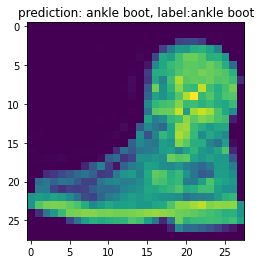

In [44]:
import matplotlib.pyplot as plt
classes = [
    "shirt",
    "trouser",
    "pullover",
    "dress",
    "coat",
    "sandal",
    "shirt",
    "sneaker",
    "bag",
    "ankle boot",
]
model.eval()
rand_idx = random.randint(0, len(validation_data) -1)
input_image, input_label = validation_data[rand_idx][0], validation_data[rand_idx][1]

with torch.no_grad():
  print(f'current data index: {rand_idx}')
  y_hat = model(input_image)
  prediction = classes[torch.argmax(y_hat.squeeze())]
  decode_label = classes[input_label]
  print(f'prediction result: {prediction}, actually: {decode_label}')
  plt.title(f'prediction: {prediction}, label:{decode_label}')
  plt.imshow(input_image.squeeze())